KeyboardInterrupt: 

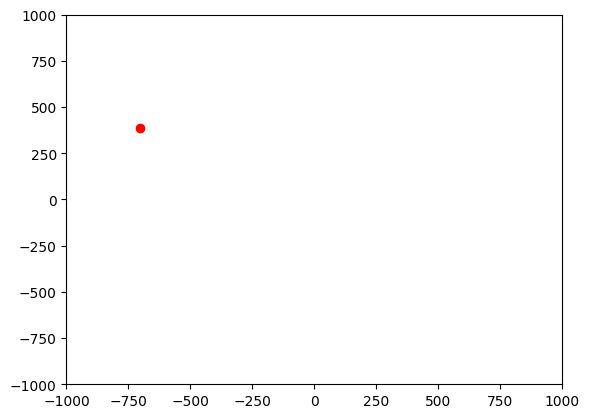

: 

In [14]:
# Import the necessary libraries
import cv2
import numpy as np
import time
from scipy.signal import blackman
from scipy.fftpack import fft2, ifft2, fftshift
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
FRAME_RATE =100



def phase_correlation(a, b):
    # Step 1: Convert the images to grayscale
    a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    b = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)

    # Step 2: Apply a window function to reduce edge effects
    window_r = blackman(a.shape[0])
    window_c = blackman(a.shape[1])
    window = np.outer(window_r, window_c)
    a = a * window
    b = b * window

    # Step 3: Compute the Fourier Transform of both images
    G_a = fft2(a)
    G_b = fft2(b)

    # Step 4: Compute the cross-power spectrum
    conj_b = np.ma.conjugate(G_b)
    R = G_a * conj_b
    R /= np.absolute(R)

    # Step 5: Compute the inverse Fourier Transform
    r = fftshift(ifft2(R).real)

    # Step 6: Find the peak in the result
    peak = np.unravel_index(np.argmax(r), r.shape)

    return peak

# Open a video capture object
cap = cv2.VideoCapture(1)  # 0 is usually the built-in webcam, 1 is the external webcam

# Initialize the position of the point
position = np.array([0, 0])

# Create a scatter plot
fig, ax = plt.subplots()
points = ax.scatter(*position, color='red')

# Set the x and y limits on the plot
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)

# In a loop, capture frames from the video capture object
ret, prev = cap.read()
while True:
    # Capture frame-by-frame
    ret, curr = cap.read()
    translation = phase_correlation(prev, curr)
    translation = np.array(translation) - np.array((240, 320)) # translation is measured from the center of the image
    translation = translation[::-1]*[1, -1] # convert from (y, x) to (x, y) and invert the y-axis
    
    # Update the position of the point
    position += translation
    
    # Update the scatter plot
    points.set_offsets(position)
    ax.relim()
    ax.autoscale_view()
    
    # Clear the previous plot and display the new plot
    clear_output(wait=True)
    display(fig)
    
    print(f"The translation between the two images is {translation} pixels")
    
    # Display the frames
    cv2.imshow('frame', curr)
    
    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Introduce delay
    time.sleep(1/FRAME_RATE) 
    prev = curr 

# Release the video capture object when done
cap.release()
cv2.destroyAllWindows()